In [1]:
import pandas as pd
import json
from dotenv import load_dotenv
import os
import time
from discharge_agent.llm.llm_utils import LLMProvider, MedicalDataExtractor
from discharge_agent.extractions.extraction import run_extraction_with_json_evaluation

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

df = pd.read_csv("data/synthetic_notes.csv")

In [2]:


# Local setup
oss_extractor = MedicalDataExtractor(
    LLMProvider.LOCAL,
    model="gpt-oss:20b",
    api_url="http://localhost:11434/api/chat"
)
mistral_extractor = MedicalDataExtractor(
    LLMProvider.LOCAL,
    model="mistral-small:22b",
    api_url="http://localhost:11434/api/chat"
)

# OpenAI setup  
gpt5_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-5-2025-08-07"
)

gpt5mini_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-5-mini-2025-08-07"
)

gpt41_extractor = MedicalDataExtractor(
    LLMProvider.OPENAI,
    api_key=OPENAI_API_KEY,
    model="gpt-4.1-2025-04-14"
)

# Anthropic setup
opus_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-opus-4-1-20250805"
)

sonnet_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-sonnet-4-20250514"
)

haiku_extractor = MedicalDataExtractor(
    LLMProvider.ANTHROPIC,
    api_key=ANTHROPIC_API_KEY, 
    model="claude-3-5-haiku-20241022"
)

In [3]:
benchmark_models = {
    "claude_sonnet": sonnet_extractor,
    "claude_opus": opus_extractor,
    "claude_haiku": haiku_extractor,
    "openai_gpt5": gpt5_extractor,
    "openai_gpt5mini": gpt5mini_extractor,
    "openai_gpt4_1": gpt41_extractor,
    "openai_oss": oss_extractor,
    "mistral_small": mistral_extractor
}

In [ ]:
timing_results = {}
all_results = {}
summary_results = {}
for model, extractor in benchmark_models.items():
    print(f"Extracting data with : {model}")
    start_time = time.time()
    results, summary = run_extraction_with_json_evaluation(df, extractor)
    end_time = time.time()
    timing_results[model] = end_time - start_time
    all_results[model] = results
    summary_results[model] = summary

In [ ]:
with open("data/processed_notes/all_extractions_multiple_providers.jsonl", "w") as f:
    for i in range(len(all_results)):
        note_extraction = {}
        for model, result in all_results.items():
            note_extraction[model] = result[i]
            
        f.write(json.dumps(note_extraction) + "\n")

In [ ]:
with open("timings.json", "w") as f:
    json.dump(timing_results, f)

In [ ]:
import json
# Read data for eval
data = []
with open("data/processed_notes/all_extractions_multiple_providers.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))
data

In [2]:
from discharge_agent.evaluation.consensus import consensus_gold_all
# Build the consensus
gold_consensus = consensus_gold_all(data, quorum=0.5)

In [3]:
from discharge_agent.evaluation.evaluate_accuracy import run_evaluation
# Compute validation summary
summary = run_evaluation(data, gold_consensus)

In [4]:
print("=== SUMMARY (per model, averaged over the 10 notes) ===")
print(summary.to_string(index=False))

=== SUMMARY (per model, averaged over the 10 notes) ===
          model  discharge_date_exact  chief_complaint_exact  primary_discharge_diagnosis_exact  discharge_disposition_exact  discharge_date_soft  chief_complaint_soft  primary_discharge_diagnosis_soft  discharge_disposition_soft  scalar_exact_acc  scalar_soft_acc   labs_p   labs_r  labs_f1   meds_p   meds_r  meds_f1  followups_p  followups_r  followups_f1  procedures_p  procedures_r  procedures_f1  all_lists_p  all_lists_r  all_lists_f1
  openai_gpt4_1                   1.0                    1.0                                1.0                          1.0                  1.0                   1.0                               1.0                         1.0             1.000              1.0 0.913333 0.950000 0.929798 1.000000 1.000000 1.000000         0.90         0.95      0.916667          0.40           0.4       0.400000     0.946494     0.972727      0.958999
openai_gpt5mini                   1.0                    1.0

# Visualization

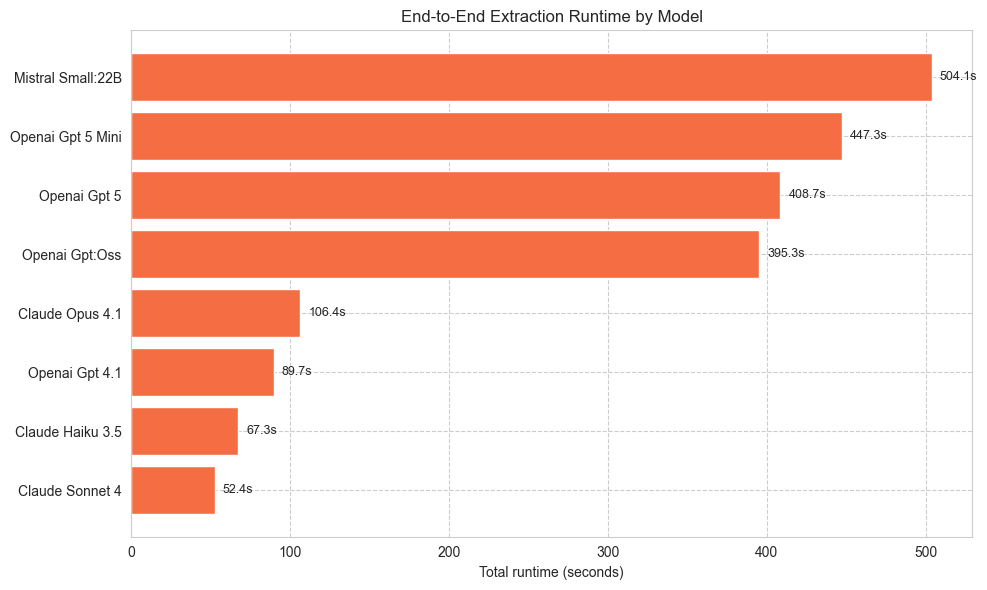

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid", {'grid.linestyle': '--'})

with open("timings.json", "r") as f:
    timings = json.load(f)


df = pd.DataFrame(list(timings.items()), columns=["model","seconds"]).sort_values("seconds").reset_index(drop=True)
df["label"] = df["model"].str.replace("_"," ").str.replace("-"," ").str.title()

fig, ax = plt.subplots(figsize=(10,6))
y = np.arange(len(df))
ax.barh(y, df["seconds"].values, color="#f46d43")

for yi, val in zip(y, df["seconds"].values):
    ax.text(val + df["seconds"].max()*0.01, yi, f"{val:.1f}s", va="center", fontsize=9)

ax.set_yticks(y)
ax.set_yticklabels(df["label"])
ax.set_xlabel("Total runtime (seconds)")
ax.set_title("End-to-End Extraction Runtime by Model")

fig.tight_layout()

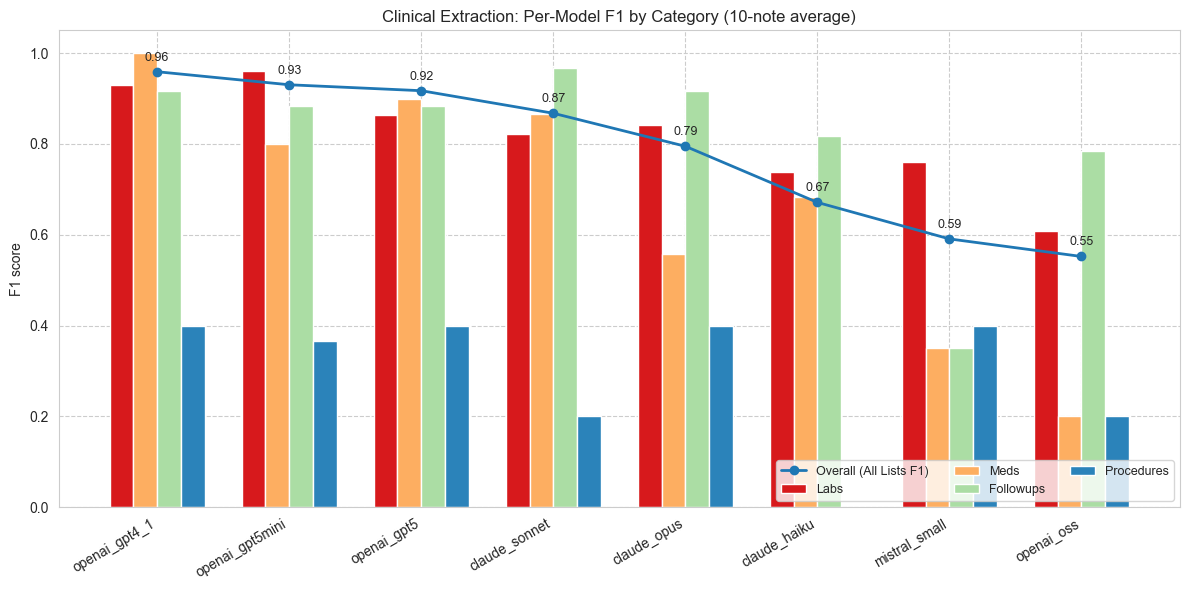

In [6]:

df = summary[['model', 'labs_f1', 'meds_f1', 'followups_f1', 'procedures_f1', 'all_lists_f1']].sort_values(by='all_lists_f1', ascending=False).reset_index(drop=True)

metrics = ["labs_f1", "meds_f1", "followups_f1", "procedures_f1"]
x = np.arange(len(df))
width = 0.18

palette = {
    0: "#d7191c",
    1: "#fdae61",
    2: "#abdda4",
    3: "#2b83ba"
}

fig, ax = plt.subplots(figsize=(12,6))
for i, m in enumerate(metrics):
    color = palette[i]
    ax.bar(x + (i-1.5)*width, df[m].values, width, color=color, label=m.replace("_f1","").title())

ax.plot(x, df["all_lists_f1"].values, marker="o", linewidth=2, label="Overall (All Lists F1)")

ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(df["model"], rotation=30, ha="right")
ax.set_ylabel("F1 score")
ax.set_title("Clinical Extraction: Per-Model F1 by Category (10-note average)")

for xi, yi in zip(x, df["all_lists_f1"].values):
    ax.annotate(f"{yi:.2f}", (xi, yi), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9)

ax.legend(ncol=3, fontsize=9, frameon=True, loc="lower right")
plt.tight_layout()

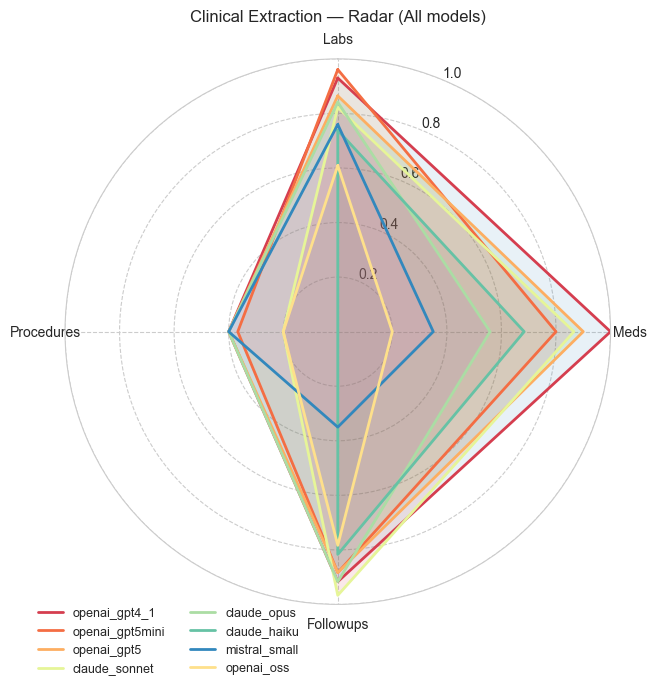

In [7]:


palette = {
    "openai_gpt4_1":   "#d53e4f",  
    "openai_gpt5mini": "#f46d43",  
    "openai_gpt5":     "#fdae61", 
    "openai_oss":      "#fee08b", 
    "claude_sonnet":   "#e6f598", 
    "claude_opus":     "#abdda4", 
    "claude_haiku":    "#66c2a5", 
    "mistral_small":   "#3288bd",
}


cats = ["Labs", "Meds", "Followups", "Procedures"]
vals = df[["labs_f1","meds_f1","followups_f1","procedures_f1"]].values

# Radar setup
N = len(cats)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Grid and ticks
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels=cats)
ax.set_ylim(0, 1.0)

# Plot each model
for i, row in df.iterrows():
    values = row[["labs_f1","meds_f1","followups_f1","procedures_f1"]].tolist()
    values += values[:1]
    color=palette[row['model']]
    ax.plot(angles, values, color=color, linewidth=2, label=row["model"])
    ax.fill(angles, values, alpha=0.10)

ax.set_title("Clinical Extraction — Radar (All models)", va='bottom')
ax.legend(loc="lower right", bbox_to_anchor=(0.45, -0.15), ncol=2, frameon=False, fontsize=9)

plt.tight_layout()

